In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rcParams.update({'font.size': 18})


The first step is to solve our 1-dimensional, azimuthally symmetric island problem as an EVP using Dedalus. 

Note, as previously, we are assuming solutions of the form,

$$\Psi(r,\theta,t) = \Re\Big\{ F(r) \,e^{in\theta}\, e^{-2i\omega\Omega t}\Big\}$$

(i.e. our solution is fully separable, thus a 1-dimensional problem) to the Topographic Rossby Wave Equation for linear barotropic CSWs. This means the problem we are solving is,

$$\frac{1}{H(r)}\partial_{rr}F + \Big[\frac{1}{r H(r)}+\partial_r(H(r)^{-1})\Big]\partial_r F+\Big[\frac{n}{\omega r}\partial_r(H(r)^{-1})-\frac{n^2}{H(r) r^2}\Big]F = 0$$
over the domain $r\in(a,1)$ subject to the boundary conditions 
$$F(r=a) = 0$$
and 
$$\partial_r F(r=1)+n F(r=1)=0.$$



Now, because we are imposing boundary conditions on the system, we will need to employ the [Tau Method](https://dedalus-project.readthedocs.io/en/latest/pages/tau_method.html) explicitly in the Dedalus solver. There are two key ways we could chose to implement the Tau Method (more notes describing this in notebook). Firstly we could elect to keep retain our system expression as a second order differential equation and include 2 $\tau$ unknowns (2 $\tau$'s required for 2 BCs) associated with polynomials $P_1$ and $P_2$ taken to be the second derivative 'lift' of the Chebyshev basis inserted in the $N-1$ and $N-2$ rows of the differential operator. Then our system becomes,

$$\frac{1}{H(r)}\partial_{rr}F + \Big[\frac{1}{r H(r)}+\partial_r(H(r)^{-1})\Big]\partial_r F+\Big[\frac{n}{\omega r}\partial_r(H(r)^{-1})-\frac{n^2}{H(r) r^2}\Big]F + \underbrace{\tau_1 V_{N-1} + \tau_2 V_{N-2}}_{\tau \textrm{ terms in second derivative basis}}= 0$$

$$F(r=a) = 0$$

$$\partial_r F(r=1)+n F(r=1)=0.$$


An alternative would be to make the substitution,
$$G = \partial_r F +\underbrace{\tau_1 U_{N-1}}_{\tau \textrm{ term in first derivative basis}}$$
such that we can express our system as the first order equation,

$$\frac{1}{H(r)}\partial_{r}G + \Big[\frac{1}{r H(r)}+\partial_r(H(r)^{-1})\Big]G+\Big[\frac{n}{\omega r}\partial_r(H(r)^{-1})-\frac{n^2}{H(r) r^2}\Big]F + \underbrace{\tau_2 U_{N-1}}_{\tau \textrm{ term in first derivative basis}}= 0$$
and our full system is,

$$ \partial_r F -G +\tau_1 U_{N-1}=0$$
$$\frac{1}{H(r)}\partial_{r}G + \Big[\frac{1}{r H(r)}+\partial_r(H(r)^{-1})\Big]G+\Big[\frac{n}{\omega r}\partial_r(H(r)^{-1})-\frac{n^2}{H(r) r^2}\Big]F + \tau_2 U_{N-1}= 0$$
$$F(r=a)=0$$
$$\partial_r F(r=1)+n F(r=1)=0.$$

We could really do either implementation, I'll probably try both and see if they give significantly different results atthe same resolution.


Also, for now we'll replicate the analytical case were $H(r)=r^{2 \alpha}$, for the first part I work things out with the simplified formulation with this $H$ form.

## Second order implementation ($H(r)=r^{2\alpha}$)

In [3]:
# Parameters
Nr = 100 # resolution in r
n  = 1 # for now, only investigate the first azimuthal mode
a  = 0.5 # portion of radial domain taken up by the island
Lr = 1 # domain in r = (a,Lr)

# for bathymetry
α = 1

In [4]:
# Basis
coord = d3.Coordinate('r')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.Chebyshev(coord, Nr, bounds=(a,Lr))
# Fields
F = dist.Field(name='F',bases=basis)
ωinv = dist.Field(name='ωinv')
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
namespace=locals()

In [5]:
# Substitutions
r = dist.local_grid(basis)

dr = lambda A: d3.Differentiate(A, coord)
lift_basis = basis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
coeff1 = dist.Field(bases=basis); coeff1['g'] = r**(-2*α)
coeff2 = dist.Field(bases=basis); coeff2['g'] = r**(-2*α-1)  
coeff3 = dist.Field(bases=basis); coeff3['g'] = r**(-1)*n
coeff4 = dist.Field(bases=basis); coeff4['g'] = n**2*r**(-2*α-2)
grad_bathy = dr(coeff1)

In [6]:
# Problem
problem_second = d3.EVP([F, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) 
problem_second.add_equation("coeff1*dr(dr(F)) + (coeff2+grad_bathy)*dr(F) + (coeff3*grad_bathy*ωinv - coeff4)*F + lift(tau_1,-1) + lift(tau_2,-2) = 0")
problem_second.add_equation("F(r=a)=0")
problem_second.add_equation("dr(F)(r=Lr)+n*F(r=Lr)=0")
# Solve
solver_second = problem_second.build_solver()
solver_second.solve_dense(solver_second.subproblems[0])

2022-08-10 15:11:42,781 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.0e-01/s


In [7]:
solver_second.eigenvalues.shape

(102,)

In [8]:
solver_second.eigenvectors.shape

(102, 102)

In [9]:
eigs = solver_second.eigenvalues
np.abs(np.sort(1/eigs[(eigs.real<np.inf)&(eigs.imag==0)]))

array([1.72813210e-01, 3.72471153e-02, 1.47012576e-02, 7.71152217e-03,
       4.72016099e-03, 3.17889447e-03, 2.28398063e-03, 1.71930500e-03,
       1.34053614e-03, 1.07428481e-03, 8.80068253e-04, 7.34084360e-04,
       6.21600947e-04, 5.33106087e-04, 4.62237172e-04, 4.04608308e-04,
       3.57116977e-04, 3.17518583e-04, 2.84156839e-04, 2.55788044e-04,
       2.31463654e-04, 2.10450072e-04, 1.92172754e-04, 1.76176561e-04,
       1.62097176e-04, 1.49640200e-04, 1.38565651e-04, 1.28676322e-04,
       1.19808953e-04, 1.11827452e-04, 1.04617648e-04, 9.80831828e-05,
       9.21422817e-05, 8.67251805e-05, 8.17720706e-05, 7.72314417e-05,
       7.30587372e-05, 6.92152578e-05, 6.56672614e-05, 6.23852200e-05,
       5.93432038e-05, 5.65183675e-05, 5.38905204e-05, 5.14417647e-05,
       4.91561880e-05, 4.70196102e-05, 4.50193754e-05, 4.31440457e-05,
       4.13834596e-05, 3.97291424e-05, 3.81708206e-05, 3.67000107e-05,
       3.53255884e-05, 3.40183955e-05, 3.27267361e-05, 3.16293156e-05,
      

In [10]:
ω_roots_second = np.flip(np.sort(np.abs(np.real(1/solver_second.eigenvalues))))[:-2]
mode_order = np.flip(np.argsort(np.abs(np.real(1/solver_second.eigenvalues))))[:-2]


In [11]:
ω_roots_second[:5]
# MATLAB gave -0.172813208772900	-0.0372471149452946	-0.0147012574608315	-0.00771152207572732	-0.00472016099528606

array([0.17281321, 0.03724712, 0.01470126, 0.00771152, 0.00472016])

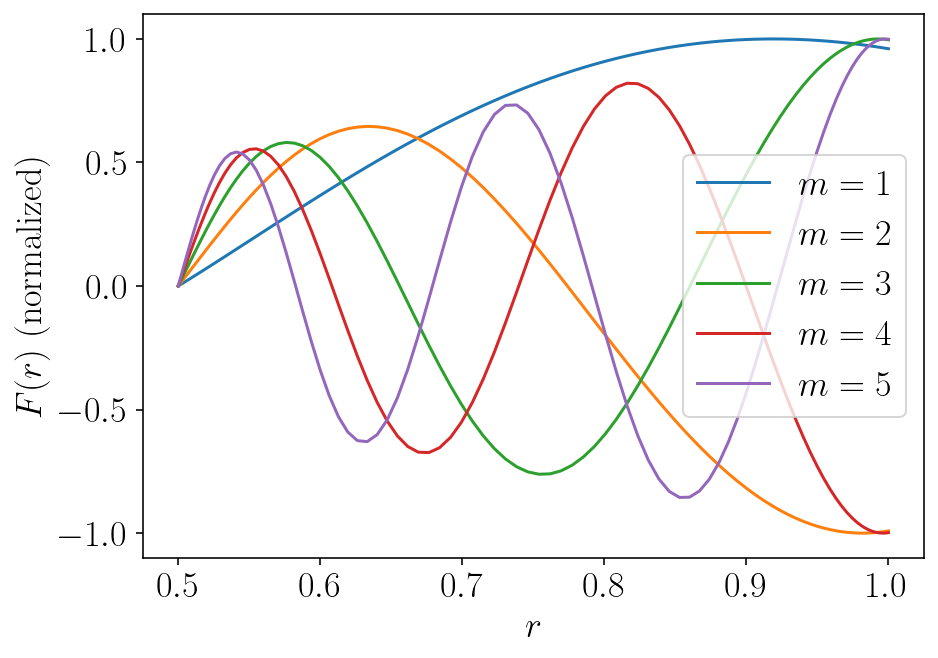

In [12]:
fig,ax = plt.subplots(1,1, figsize=(7,5)) #note this is for n=1
for i in range(5):
    solver_second.set_state(mode_order[i], solver_second.subsystems[0])
    Fg = (F['g']/F['g'][1]).real
    ax.plot(r, Fg/np.max(np.abs(Fg)), label='$m=$ '+str(i+1)+'')
ax.legend(loc=0)
ax.set_ylabel('$F(r)$ (normalized)'); ax.set_xlabel('$r$')
plt.show()

## First order implementation ($H(r)=r^{2\alpha}$)

In [13]:
# Substitutions (some carry over)
lift_basis = basis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
Fr = dr(F) + lift(tau_1)

In [14]:
# Problem
problem_first = d3.EVP([F, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) # note ω here is really n/ω
problem_first.add_equation("coeff1*dr(Fr) + (coeff2+grad_bathy)*Fr + (coeff3*grad_bathy*ωinv - coeff4)*F + lift(tau_2) = 0")
problem_first.add_equation("F(r=a)=0")
problem_first.add_equation("dr(F)(r=Lr)+n*F(r=Lr)=0")
# Solve
solver_first = problem_first.build_solver()
solver_first.solve_dense(solver_first.subproblems[0])
evals = np.sort(solver_first.eigenvalues)

2022-08-10 15:11:53,250 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


In [15]:
ω_roots_first = np.flip(np.sort(np.abs(np.real(1/solver_first.eigenvalues))))[:-2]

In [16]:
ω_roots_first[:5]
# MATLAB gave -0.172813208772900	-0.0372471149452946	-0.0147012574608315	-0.00771152207572732	-0.00472016099528606

array([0.17281321, 0.03724712, 0.01470126, 0.00771152, 0.00472016])

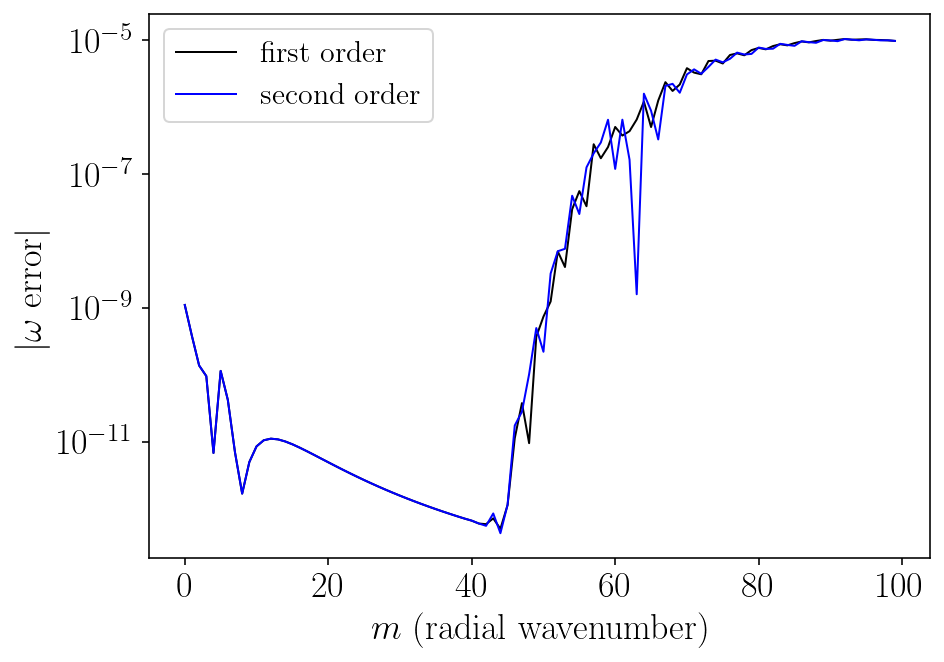

In [17]:
# compare to results of the M=48  MATLAB output (analytical)
# it looks like we can generally be happy with the first Nr/2 roots
analytical_ω_roots = np.array([-0.172813208772900,-0.0372471149452946,-0.0147012574608315,-0.00771152207572732,-0.00472016099528606,-0.00317889435431428,-0.00228398059017129,-0.00171930499340991,-0.00134053613467757,-0.00107428480074740,-0.000880068244640553,-0.000734084349454644,-0.000621600935898217,-0.000533106076382622,-0.000462237162252809,-0.000404608299088855,-0.000357116969230404,-0.000317518575743731,-0.000284156833150745,-0.000255788038346567,-0.000231463648879540,-0.000210450067891273,-0.000192172750608739,-0.000176176557305662,-0.000162097172668693,-0.000149640197817735,-0.000138565648544466,-0.000128676319492406,-0.000119808950598958,-0.000111827450344015,-0.000104617646216949,-9.80831814038669e-05,-9.21422803729303e-05,-8.67251792902828e-05,-8.17720695701647e-05,-7.72314407165505e-05,-7.30587362566698e-05,-6.92152569487540e-05,-6.56672606113127e-05,-6.23852193012342e-05,-5.93432031767324e-05,-5.65183669432562e-05,-5.38905198186528e-05,-5.14417638485602e-05,-4.91561884333146e-05,-4.70196113000114e-05,-4.50193580215469e-05,-4.31440736638859e-05,-4.13835613206238e-05,-3.97286432364033e-05,-3.81710409786296e-05,-3.67032717291897e-05,-3.53185582647380e-05,-3.40107505990288e-05,-3.27742575921391e-05,-3.16039871036640e-05,-3.04952934914783e-05,-2.94439314434935e-05,-2.84460152841998e-05,-2.74979830264283e-05,-2.65965645463511e-05,-2.57387533499646e-05,-2.49217814752276e-05,-2.41430971380898e-05,-2.34003447848611e-05,-2.26913472593799e-05,-2.20140898325774e-05,-2.13667058754309e-05,-2.07474639848454e-05,-2.01547563964833e-05,-1.95870885395925e-05,-1.90430696069918e-05,-1.85214040290049e-05,-1.80208837536563e-05,-1.75403812471560e-05,-1.70788431388808e-05,-1.66352844439134e-05,-1.62087833039218e-05,-1.57984761939061e-05,-1.54035535482399e-05,-1.50232557646076e-05,-1.46568695489794e-05,-1.43037245687636e-05,-1.39631903847944e-05,-1.36346736359169e-05,-1.33176154526810e-05,-1.30114890790803e-05,-1.27157976834281e-05,-1.24300723413743e-05,-1.21538701757647e-05,-1.18867726395573e-05,-1.16283839293607e-05,-1.13783295183587e-05,-1.11362547984634e-05,-1.09018238225017e-05,-1.06747181380995e-05,-1.04546357057032e-05,-1.02412898938716e-05,-1.00344085455944e-05,-9.83373310995838e-06])
analytical_ω_roots = np.abs(analytical_ω_roots)
fig,ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(np.abs(analytical_ω_roots-ω_roots_first), 'k-', linewidth=1, label='first order')
ax.plot(np.abs(analytical_ω_roots-ω_roots_second), 'b-', linewidth=1, label='second order')
ax.set_yscale('log')
ax.legend(loc=0,fontsize=15)
ax.set_xlabel(r'$m$ (radial wavenumber)')
ax.set_ylabel(r'$|\omega$ error$|$')
plt.show()

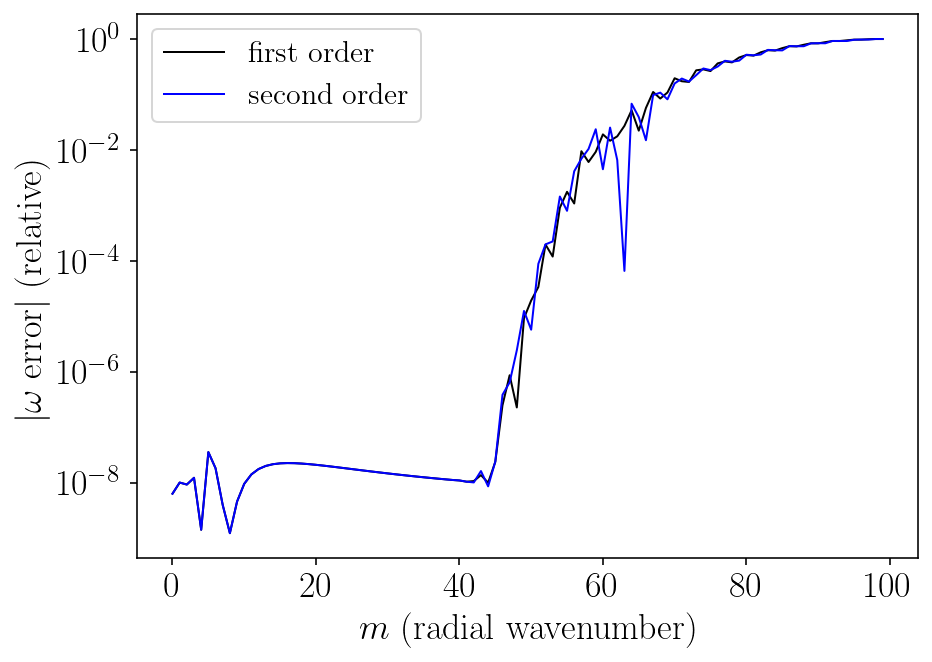

In [18]:
# compare to results of the M=48  MATLAB output (analytical)
# it looks like we can generally be happy with the first Nr/2 roots
analytical_ω_roots = np.array([-0.172813208772900,-0.0372471149452946,-0.0147012574608315,-0.00771152207572732,-0.00472016099528606,-0.00317889435431428,-0.00228398059017129,-0.00171930499340991,-0.00134053613467757,-0.00107428480074740,-0.000880068244640553,-0.000734084349454644,-0.000621600935898217,-0.000533106076382622,-0.000462237162252809,-0.000404608299088855,-0.000357116969230404,-0.000317518575743731,-0.000284156833150745,-0.000255788038346567,-0.000231463648879540,-0.000210450067891273,-0.000192172750608739,-0.000176176557305662,-0.000162097172668693,-0.000149640197817735,-0.000138565648544466,-0.000128676319492406,-0.000119808950598958,-0.000111827450344015,-0.000104617646216949,-9.80831814038669e-05,-9.21422803729303e-05,-8.67251792902828e-05,-8.17720695701647e-05,-7.72314407165505e-05,-7.30587362566698e-05,-6.92152569487540e-05,-6.56672606113127e-05,-6.23852193012342e-05,-5.93432031767324e-05,-5.65183669432562e-05,-5.38905198186528e-05,-5.14417638485602e-05,-4.91561884333146e-05,-4.70196113000114e-05,-4.50193580215469e-05,-4.31440736638859e-05,-4.13835613206238e-05,-3.97286432364033e-05,-3.81710409786296e-05,-3.67032717291897e-05,-3.53185582647380e-05,-3.40107505990288e-05,-3.27742575921391e-05,-3.16039871036640e-05,-3.04952934914783e-05,-2.94439314434935e-05,-2.84460152841998e-05,-2.74979830264283e-05,-2.65965645463511e-05,-2.57387533499646e-05,-2.49217814752276e-05,-2.41430971380898e-05,-2.34003447848611e-05,-2.26913472593799e-05,-2.20140898325774e-05,-2.13667058754309e-05,-2.07474639848454e-05,-2.01547563964833e-05,-1.95870885395925e-05,-1.90430696069918e-05,-1.85214040290049e-05,-1.80208837536563e-05,-1.75403812471560e-05,-1.70788431388808e-05,-1.66352844439134e-05,-1.62087833039218e-05,-1.57984761939061e-05,-1.54035535482399e-05,-1.50232557646076e-05,-1.46568695489794e-05,-1.43037245687636e-05,-1.39631903847944e-05,-1.36346736359169e-05,-1.33176154526810e-05,-1.30114890790803e-05,-1.27157976834281e-05,-1.24300723413743e-05,-1.21538701757647e-05,-1.18867726395573e-05,-1.16283839293607e-05,-1.13783295183587e-05,-1.11362547984634e-05,-1.09018238225017e-05,-1.06747181380995e-05,-1.04546357057032e-05,-1.02412898938716e-05,-1.00344085455944e-05,-9.83373310995838e-06])
analytical_ω_roots = np.abs(analytical_ω_roots)
fig,ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(np.abs(analytical_ω_roots-ω_roots_first)/analytical_ω_roots, 'k-', linewidth=1, label='first order')
ax.plot(np.abs(analytical_ω_roots-ω_roots_second)/analytical_ω_roots, 'b-', linewidth=1, label='second order')
ax.set_yscale('log')
ax.legend(loc=0,fontsize=15)
ax.set_xlabel(r'$m$ (radial wavenumber)')
ax.set_ylabel(r'$|\omega$ error$|$ (relative)')
plt.show()

It looks like at least in this case the first and second order solvers give us a comparable number of reliable roots.

## Number of resolvable modes

Based on the above I want to look at hoe many roots we can obtain (to an error threshold of $10^{-8}$) as a function of the radial resolution of our solver. I don't imagine we'll ever have use for more than 50 roots so that will be the cap of what we explore. We'll use the second order method here.

In [19]:
analytical_ω_roots = np.array([-0.172813208772900,-0.0372471149452946,-0.0147012574608315,-0.00771152207572732,-0.00472016099528606,-0.00317889435431428,-0.00228398059017129,-0.00171930499340991,-0.00134053613467757,-0.00107428480074740,-0.000880068244640553,-0.000734084349454644,-0.000621600935898217,-0.000533106076382622,-0.000462237162252809,-0.000404608299088855,-0.000357116969230404,-0.000317518575743731,-0.000284156833150745,-0.000255788038346567,-0.000231463648879540,-0.000210450067891273,-0.000192172750608739,-0.000176176557305662,-0.000162097172668693,-0.000149640197817735,-0.000138565648544466,-0.000128676319492406,-0.000119808950598958,-0.000111827450344015,-0.000104617646216949,-9.80831814038669e-05,-9.21422803729303e-05,-8.67251792902828e-05,-8.17720695701647e-05,-7.72314407165505e-05,-7.30587362566698e-05,-6.92152569487540e-05,-6.56672606113127e-05,-6.23852193012342e-05,-5.93432031767324e-05,-5.65183669432562e-05,-5.38905198186528e-05,-5.14417638485602e-05,-4.91561884333146e-05,-4.70196113000114e-05,-4.50193580215469e-05,-4.31440736638859e-05,-4.13835613206238e-05,-3.97286432364033e-05])
analytical_ω_roots = np.abs(analytical_ω_roots)

In [20]:
# Parameters
Nr_range = np.arange(10,110) # resolution in r (start low)
n  = 1 # for now, only investigate the first azimuthal mode
a  = 0.5 # portion of radial domain taken up by the island
Lr = 1 # domain in r = (a,Lr)

# for bathymetry
α = 1

In [ ]:
number_resolved_roots_second = np.zeros(100)
number_resolved_roots_first = np.zeros(100)


In [ ]:
for i in range(100):
    Nr = Nr_range[i]
    # Basis
    coord = d3.Coordinate('r')
    dist = d3.Distributor(coord, dtype=np.complex128)
    basis = d3.Chebyshev(coord, Nr, bounds=(a,Lr))
    # Fields
    F = dist.Field(name='F',bases=basis)
    ωinv = dist.Field(name='ωinv')
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    # Substitutions
    r = dist.local_grid(basis)
    dr = lambda A: d3.Differentiate(A, coord)
    lift_basis = basis.derivative_basis(2)
    lift = lambda A, n: d3.Lift(A, lift_basis, n)
    coeff1 = dist.Field(bases=basis); coeff1['g'] = r**(-2*α)
    coeff2 = dist.Field(bases=basis); coeff2['g'] = r**(-2*α-1)  
    coeff3 = dist.Field(bases=basis); coeff3['g'] = r**(-1)*n
    coeff4 = dist.Field(bases=basis); coeff4['g'] = n**2*r**(-2*α-2)
    grad_bathy = dr(coeff1)
    # Problem
    problem_second = d3.EVP([F, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) # note ω here is really n/ω
    problem_second.add_equation("coeff1*dr(dr(F)) + (coeff2+grad_bathy)*dr(F) + (coeff3*grad_bathy*ωinv - coeff4)*F + lift(tau_1,-1) + lift(tau_2,-2) = 0")
    problem_second.add_equation("F(r=a)=0")
    problem_second.add_equation("dr(F)(r=Lr)+n*F(r=Lr)=0")
    # Solve
    solver_second = problem_second.build_solver()
    solver_second.solve_dense(solver_second.subproblems[0])
    ω_roots_second = np.flip(np.sort(np.abs(np.real(1/solver_second.eigenvalues))))[:-2]
    if Nr<50:
        error = np.abs(analytical_ω_roots[:Nr]-ω_roots_second)
    else:
        error = np.abs(analytical_ω_roots-ω_roots_second[:50])
    resolved = len(error[error<1e-8])
    number_resolved_roots_second[i] = resolved


In [ ]:
for i in range(100):
    Nr = Nr_range[i]
    # Basis
    coord = d3.Coordinate('r')
    dist = d3.Distributor(coord, dtype=np.complex128)
    basis = d3.Chebyshev(coord, Nr, bounds=(a,Lr))
    # Fields
    F = dist.Field(name='F',bases=basis)
    ωinv = dist.Field(name='ωinv')
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    # Substitutions
    r = dist.local_grid(basis)
    dr = lambda A: d3.Differentiate(A, coord)
    lift_basis = basis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    coeff1 = dist.Field(bases=basis); coeff1['g'] = r**(-2*α)
    coeff2 = dist.Field(bases=basis); coeff2['g'] = r**(-2*α-1)  
    coeff3 = dist.Field(bases=basis); coeff3['g'] = r**(-1)*n
    coeff4 = dist.Field(bases=basis); coeff4['g'] = n**2*r**(-2*α-2)
    Fr = dr(F) + lift(tau_1)
    grad_bathy = dr(coeff1)

     # Problem
    problem_first = d3.EVP([F, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) # note ω here is really n/ω
    problem_first.add_equation("coeff1*dr(Fr) + (coeff2+grad_bathy)*Fr + (coeff3*grad_bathy*ωinv - coeff4)*F + lift(tau_2) = 0")
    problem_first.add_equation("F(r=a)=0")
    problem_first.add_equation("dr(F)(r=Lr)+n*F(r=Lr)=0")
    # Solve
    solver_first = problem_first.build_solver()
    solver_first.solve_dense(solver_first.subproblems[0])
    evals = np.sort(solver_first.eigenvalues)   
    ω_roots_first = np.flip(np.sort(np.abs(np.real(1/solver_first.eigenvalues))))[:-2]    
    if Nr<50:
        error = np.abs(analytical_ω_roots[:Nr]-ω_roots_first)
    else:
        error = np.abs(analytical_ω_roots-ω_roots_first[:50])
    resolved = len(error[error<1e-8])
    number_resolved_roots_first[i] = resolved


In [21]:
#np.savetxt('./resolved_roots_symmetric_island.txt', (np.array([Nr_range,number_resolved_roots_first,number_resolved_roots_second]).T), header='[N], [first order], [second order]')
array = np.loadtxt('Figures/resolved_roots_symmetric_island.txt', skiprows=1)
Nr_range = array[:,0]
number_resolved_roots_first = array[:,1]
number_resolved_roots_second = array[:,2]


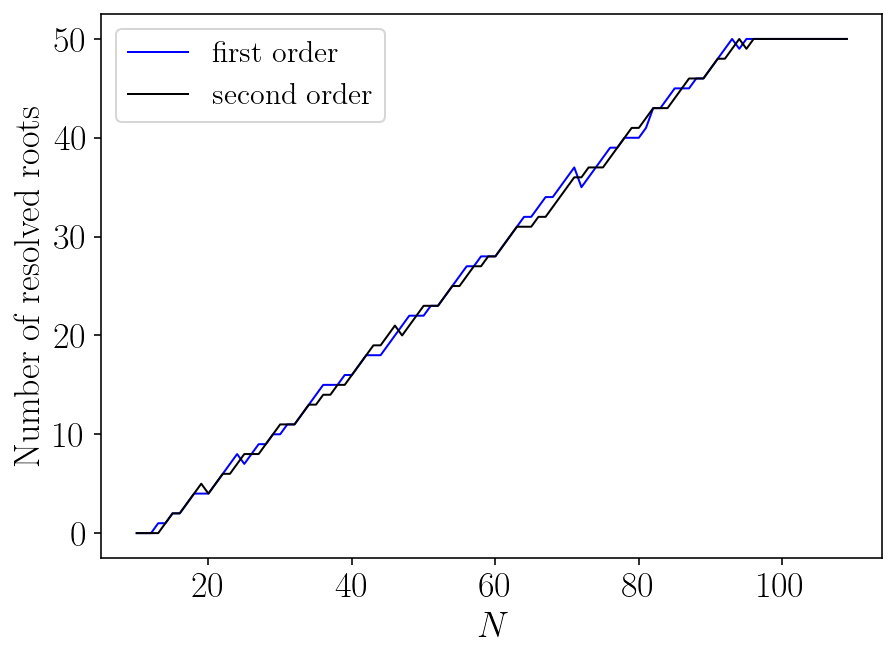

In [22]:
fig,ax = plt.subplots(1,1, figsize=(7,5)) #note this is for n=1
ax.plot(Nr_range, number_resolved_roots_first, 'b-', linewidth=1, label='first order')
ax.plot(Nr_range, number_resolved_roots_second, 'k-', linewidth=1, label='second order')
# ax.plot(Nr_range,0.5*Nr_range, 'r--')

ax.legend(loc=0,fontsize=15)
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'Number of resolved roots')
plt.savefig('Figures/resolved_roots_symmetric_island.png',dpi=150,bbox_inches='tight', facecolor='white')
plt.show()

Note: even if we can resolve these frequencies with decent accuracy sometimes the eigenvectors will look clunky.

But yeah basically can resolve $N/2$ modes or slightly less.

## Replicate dispersion relation with numerical solutions (2nd order solution)

In [23]:
number_resolved_roots_second[np.argmin(np.abs(Nr_range-100))] 
# note I checked for one other value of n (5) and the resolution wav similar.

50.0

In [24]:
# Parameters
Nr = 100 # resolution in r
n_list  = np.arange(1,51)
a  = 0.5 # portion of radial domain taken up by the island
Lr = 1 # domain in r = (a,Lr)

# for bathymetry
α = 1

In [25]:
# Basis
coord = d3.Coordinate('r')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.Chebyshev(coord, Nr, bounds=(a,Lr))
# Fields
F = dist.Field(name='F',bases=basis)
ωinv = dist.Field(name='ωinv')
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
namespace=locals()

In [26]:
# Substitutions
r = dist.local_grid(basis)

dr = lambda A: d3.Differentiate(A, coord)
lift_basis = basis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
coeff1 = dist.Field(bases=basis); coeff1['g'] = r**(-2*α)
coeff2 = dist.Field(bases=basis); coeff2['g'] = r**(-2*α-1)  
coeff3 = dist.Field(bases=basis); coeff3['g'] = r**(-1)#*n
coeff4 = dist.Field(bases=basis); coeff4['g'] = r**(-2*α-2)# n**2
grad_bathy = dr(coeff1)

In [27]:
def ω_roots_n(n):
    # Problem
    problem = d3.EVP([F, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) # note ω here is really n/ω
    problem.namespace['n'] = n
    problem.add_equation("coeff1*dr(dr(F)) + (coeff2+grad_bathy)*dr(F) + (coeff3*n*grad_bathy*ωinv - coeff4*n**2)*F + lift(tau_1,-1) + lift(tau_2,-2) = 0")
    problem.add_equation("F(r=a)=0")
    problem.add_equation("dr(F)(r=Lr)+n*F(r=Lr)=0")
    # Solve
    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0])
    ω_roots = np.flip(np.sort(np.abs(np.real(1/solver.eigenvalues))))[:-2]
    return ω_roots

evals = np.array([ω_roots_n(n)[:50] for n in n_list])

2022-08-10 15:12:12,132 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.1e-01/s
2022-08-10 15:12:12,272 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s
2022-08-10 15:12:12,380 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s
2022-08-10 15:12:12,465 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2022-08-10 15:12:12,564 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2022-08-10 15:12:12,656 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2022-08-10 15:12:12,780 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s
2022-08-10 15:12:12,898 subsystems 0/1 INFO :: Building subproblem matrices 

In [29]:
from collections import OrderedDict


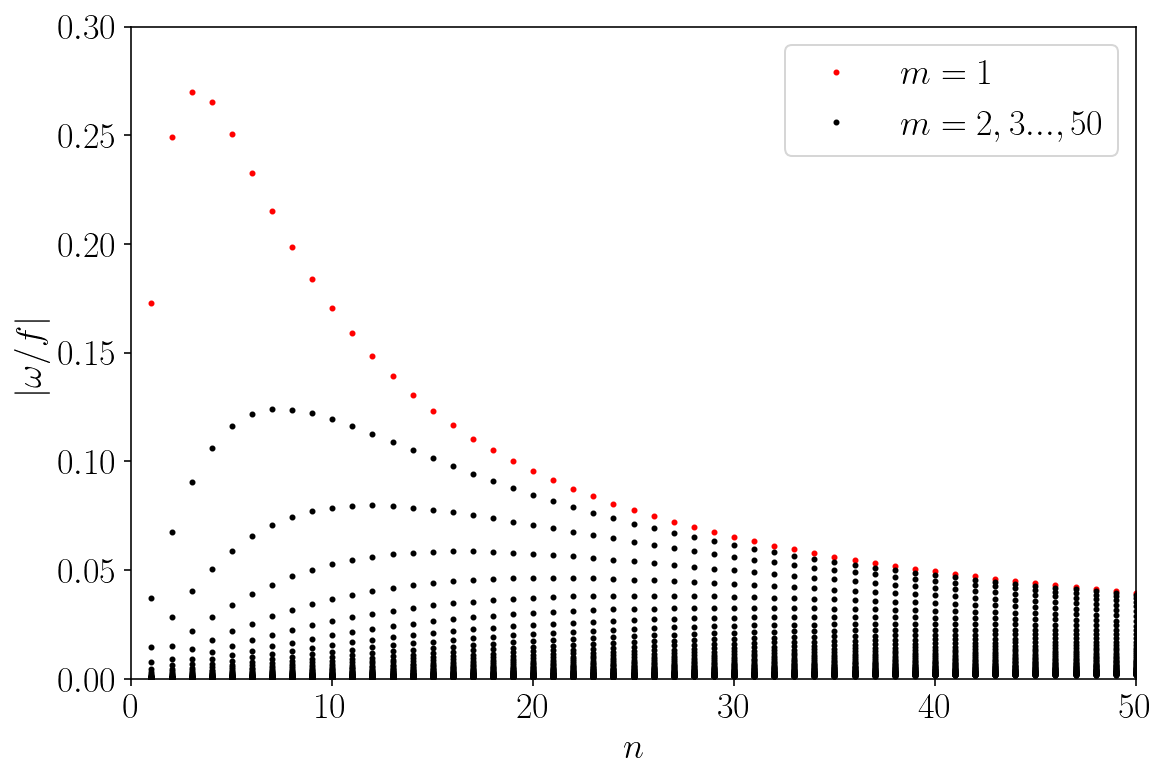

In [30]:
fig,ax = plt.subplots(1,1, figsize=(9,6)) 
ax.plot(n_list[:50], evals[:,0], 'ro', markersize=2, label='$m=1$')
ax.plot(n_list[:50], evals[:,1:], 'ko', markersize=2, label='$m=2,3...,50$')
ax.set_ylim([0,0.3]);ax.set_xlim([0,50])
ax.set_ylabel('$|\omega/f|$'); ax.set_xlabel('$n$'); #ax.legend(loc=1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [36]:
np.flip(np.sort(evals[:,0]))

array([0.26999368, 0.26529658, 0.25054816, 0.2491165 , 0.23284011,
       0.21518493, 0.19875022, 0.18389461, 0.17281321, 0.17063394,
       0.15884937, 0.14837941, 0.13905954, 0.13073796, 0.12328078,
       0.11657242, 0.11051416, 0.10502204, 0.10002473, 0.09546154,
       0.09128075, 0.08743811, 0.08389564, 0.08062062, 0.07758475,
       0.07476346, 0.07213536, 0.0696817 , 0.06738606, 0.06523394,
       0.06321254, 0.06131052, 0.05951778, 0.05782531, 0.05622504,
       0.05470975, 0.05327293, 0.05190872, 0.05061181, 0.0493774 ,
       0.04820112, 0.04707901, 0.04600744, 0.04498311, 0.04400299,
       0.0430643 , 0.04216449, 0.04130121, 0.0404723 , 0.03967577])

In [38]:
np.flip(np.argsort(evals[:,0]))+1

array([ 3,  4,  5,  2,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [34]:
np.flip(np.sort(evals[:,1]))

array([0.12389291, 0.12379969, 0.12215829, 0.12169132, 0.11951429,
       0.11625549, 0.11621389, 0.1126519 , 0.10888828, 0.10625104,
       0.10508881, 0.10133521, 0.09767972, 0.09415423, 0.09077673,
       0.09046359, 0.08755579, 0.08449367, 0.08158848, 0.0788357 ,
       0.07622917, 0.07376183, 0.07142619, 0.06921465, 0.06765058,
       0.0671197 , 0.06513408, 0.06325085, 0.06146343, 0.05976563,
       0.05815167, 0.05661613, 0.05515399, 0.05376056, 0.0524315 ,
       0.05116279, 0.0499507 , 0.04879176, 0.04768276, 0.04662072,
       0.04560289, 0.04462669, 0.04368974, 0.04278983, 0.04192489,
       0.04109301, 0.0402924 , 0.0395214 , 0.03877844, 0.03724712])